In [2]:
import numpy as np
import scipy.constants as const

## Task 2 (ts_script.pdf)

In [14]:
h = const.h
c = const.c
n = 5e19 #m**-3
L = 1e-2 #m**3
V = L**3
A = L**2
R = 2 #m
rl = 0.3 #m
E_laser = 10 #J
wavelen = 694.3e-9 #m
sigma = 6.65e-29 #m**2

In [15]:
Ne = n*V
probability = (sigma/A)
Nscattered = Ne*probability
fc = rl**2/(4*R**2)
fph = Nscattered*fc

print("fraction of photons scattered: ",fph)

E_photon = (h*c)/wavelen
N_ph = E_laser/E_photon
Ncol = fph*N_ph

print("Number of photons scattered: ",Ncol)

fraction of photons scattered:  1.8703125e-13
Number of photons scattered:  6537092.184398983


**Implications:** If we want SNR to be x, we must deploy a laser with an energy of $\approx x\cdot10^{13}$. To collect with high temporal resolution, we need this energy to be delivered quickly, i.e. a high laser repition rate. High energy + high repition rate requirement -> high power laser.

## Task 3

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# read in data
intensity  = np.loadtxt('intensity.dat')        # 2D array of CCD counts data
wavelength = np.loadtxt('lambda.dat')           # 2D array of wavelength data
radius     = np.loadtxt('radius.dat')           # 1D array of major radii
angle      = np.loadtxt('angle.dat')            # 1D array of scattering angles

In [40]:
intensity.shape, radius.shape, angle.shape, wavelength.shape

((284, 302), (284,), (284,), (284, 302))

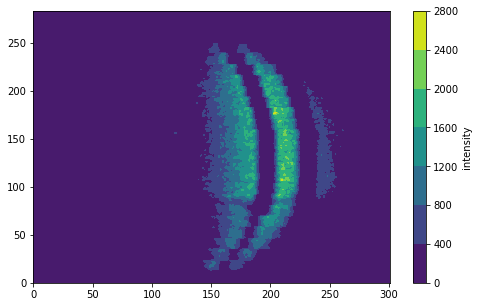

In [322]:
#visualise CCD array to decide axis
plt.rcParams["figure.figsize"] = (8,5)

plt.contourf(intensity)
plt.colorbar(label="intensity")

-> horizontal axis (302 entries) should be wavelength and vertical axis (284 entries) should be position as we expect smooth evolution of emitted intensity in space but discrete resonances in frequency space. Also obvious as position and angle array dimension in 284, so 284 entry axis must be spatial. <br>

From values in position we can infer its in units meters. From knowing ruby laser has wavelength of ~694 nm, we can infer that wavelength 0-8000 is in units $10^{-10}$, i.e. Angstrom.

**Interpretation:** <i>Each radius maps to one angle and one wavelength axis</i>. <br>
We can visualize this only in the 2D contoruf plot by simply choosing one of wavelength axis as an approximation. For calculations we then need to always choose the corresponding wavelength axis for each radial position (See 1D plot below).

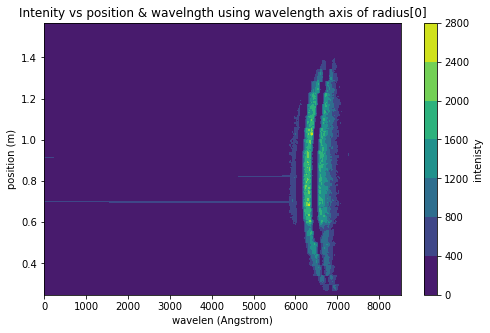

In [323]:
x = wavelength[0,:] #take the axis of radius[0] for visualisation
y = radius

plt.contourf(x,y,intensity)
plt.colorbar(label="intenisty")
plt.xlabel("wavelen (Angstrom)")
plt.ylabel("position (m)")
plt.title("Intenity vs position & wavelngth using wavelength axis of radius[0]")
plt.show()

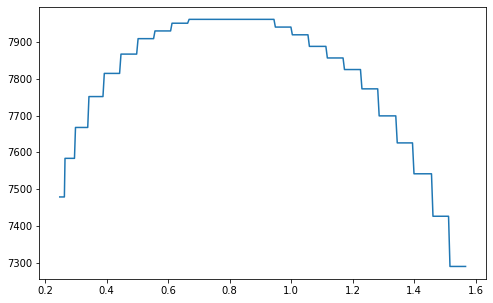

In [367]:
#look at wavelength at fixed index = 100 vs position to see how wrong above axis fixig is
plt.plot(radius,wavelength[:,100])

In [326]:
#interpolate all the data to a common wavelength 
#axis for correct visualisation

#first find min and max
for i in range(len(radius)):
    if i == 0:
        minLambda = min(wavelength[i,:])
        maxLambda = max(wavelength[i,:])
    else:
        NewMinLambda = min(wavelength[i,:])
        NewMaxLambda = max(wavelength[i,:])
        if NewMinLambda < minLambda:
            minLambda = NewMinLamda
        if NewMaxLambda > maxLambda:
            maxLambda = NewMaxLambda
            
print("abolute minLambda is",minLambda)
print("abolute maxLambda is",maxLambda)

wavelength2 = np.linspace(minLambda,maxLambda,1000)
intensity2 = np.zeros((len(radius),len(wavelength2)))
for i in range(len(radius)):
    xp = np.flip(wavelength[i,:])
    fp = intensity[i,:]
    
    intensity2[i] = np.interp(wavelength2,xp,fp)

abolute minLambda is 0.0
abolute maxLambda is 9011.5


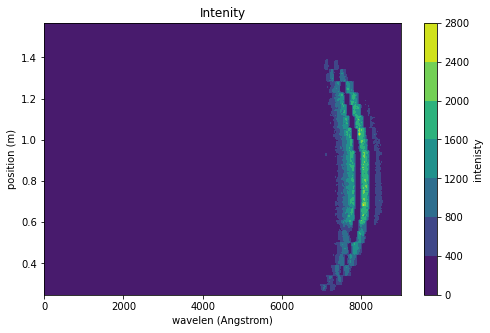

In [365]:
#Does not work yet, but not really necessary for calculation
x = wavelength2
y = radius

plt.contourf(x,y,intensity2)
plt.colorbar(label="intenisty")
plt.xlabel("wavelen (Angstrom)")
plt.ylabel("position (m)")
plt.title("Intenity")
plt.show()

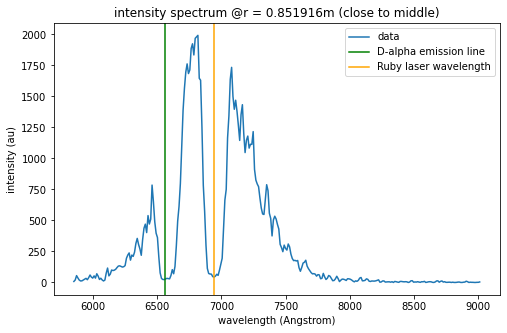

In [351]:
#plot spectrum at one radial position with correct wavelength axis
radius_idx = 140 #change this for spectra at different locations

plt.plot(wavelength[radius_idx,:],intensity[radius_idx,:],label="data")

Dalpha = 6562.8 #Angstrom
ruby = 6943 #Angstrom

plt.axvline(x=Dalpha,color="green",label="D-alpha emission line")
plt.axvline(x=ruby,color="orange",label="Ruby laser wavelength")

plt.xlabel("wavelength (Angstrom)")
plt.ylabel("intensity (au)")
plt.title("intensity spectrum @r = "+str(radius[radius_idx])+"m (close to middle)")
plt.legend(loc="best")
plt.show()

In [353]:
Brighest_lambda = np.argmax(intensity[radius_idx,:])
wavelength[radius_idx,Brighest_lambda]

6817.0

**Explanation:** The spectrum shows a broadened spectrum around a peak corresponding to a wavelength of $\lambda = 681.7 nm$. Since the doppler shifted intensity of the Thomson scattered light effectively probes the electron distribution funtion a doppler broadening described by a gaussian due to Maxwellian velocity distribution would be expected. <br>
However, we also see two clear valleys in the distribution that would usually not be expected. There are two specific emission lines which need to be filtered out such that the received signal is not flooded by these emissions:
1. The reflected laser light from the ruby laser @694.3 nm
2. The strongly emitting plasma Dalpha emission line @656.28 nm

This also highlights that the actual peak of the gaussian emission spectrum which would be expected at the laser wavelength is filtered out and any fitted gaussians later should have their peak in this region. I will refer to this later again.

## Task 4

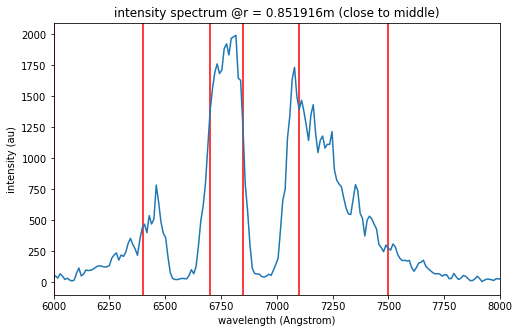

In [355]:
#filter data for fit
radius_idx = 140
xdata = wavelength[radius_idx,:]
ydata = intensity[radius_idx,:]

#test filter
plt.axvline(x=6000,color="red")
plt.axvline(x=6400,color="red")
plt.axvline(x=6700,color="red")
plt.axvline(x=6850,color="red")
plt.axvline(x=7100,color="red")
plt.axvline(x=7500,color="red")

plt.plot(xdata,ydata) 
plt.xlabel("wavelength (Angstrom)")
plt.ylabel("intensity (au)")
plt.title("intensity spectrum @r = "+str(radius[radius_idx])+"m (close to middle)")
plt.xlim(6e3,8e3)
plt.show()

In [356]:
def filter_data(xdata,ydata):
    xdata2, ydata2 = [],[]
    for i in range(len(xdata)):
        Append = False
        if xdata[i] > 6200 and xdata[i] < 6400:
            Append = True
        if xdata[i] > 6700 and xdata[i] < 6850:
            Append = True
        if xdata[i] > 7100 and xdata[i] < 7500:
            Append = True
        if Append:
            xdata2.append(xdata[i])
            ydata2.append(ydata[i])
    return xdata2, ydata2

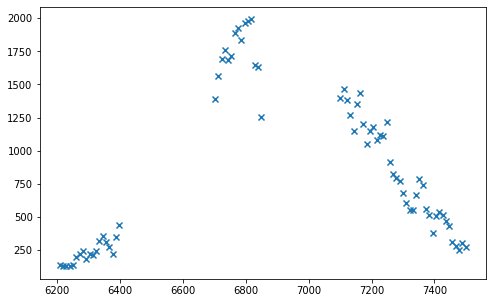

In [357]:
#plot filtered data
xdata2, ydata2 = filter_data(xdata,ydata)
plt.scatter(xdata2, ydata2,marker="x")

In [358]:
#fit spectrum for one position
kb = const.k
me = const.m_e
c = const.c
radius_idx = 140

def spectrum(lambda_s,Te,A0):
    lambda_i=6943
    theta = angle[int(radius_idx)]
    eV2J = 1.602e-19
    beta_th = np.sqrt(2*Te*eV2J/(me*c**2)) #omit boltzmann const. and insert eV to J -> T in eV
    sigma_lambda = lambda_i*beta_th*np.sqrt(2)*np.sin(theta/2)
    
    intensity = A0*np.exp(-0.5*((lambda_s-lambda_i)/sigma_lambda)**2)
    return intensity


popt, cov = curve_fit(spectrum,xdata2,ydata2,p0=[1e3,2e3])

print("Te = "+str(popt[0])+"eV @r= "+str(radius[radius_idx])+"m")

Te = 378.03814504346116eV @r= 0.851916m


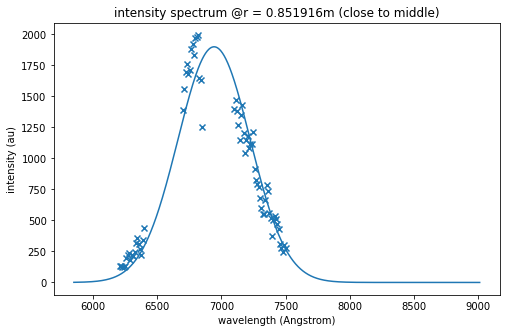

In [359]:
#look at fit result
plt.scatter(xdata2, ydata2,marker="x")

x = np.linspace(min(xdata),max(xdata),1000)
plt.plot(x,spectrum(x,popt[0],popt[1]))

plt.xlabel("wavelength (Angstrom)")
plt.ylabel("intensity (au)")
plt.title("intensity spectrum @r = "+str(radius[radius_idx])+"m (close to middle)")
plt.show()

In [362]:
maxFit = np.argmax(spectrum(x,popt[0],popt[1]))
print("fitted gaussian has peak at: ",x[maxFit])

fitted gaussian has peak at:  6942.4639639639645


**Note:** As explained earlier at the end of section 3, we see that the peak of the gaussian is baiscally at the wavelength of the laser, even though this wavelength was filtered out. Hence, fits matches expectation.

### Now do fit for all positions

In [368]:
#cut beginning and end data
front_cut = 15
back_cut = 30
radius2 = radius[front_cut:-back_cut]

Te = np.zeros(len(radius2))
Te_errors = np.zeros(len(radius2))

for i in range(len(radius2)): 
    radius_idx = i+front_cut
    xdata = wavelength[radius_idx,:]
    ydata = intensity[radius_idx,:]
    xdata2, ydata2 = filter_data(xdata,ydata)
    popt, cov = curve_fit(spectrum,xdata2,ydata2,p0=[300,2e3])
    
    Te_errors[i] = np.sqrt(cov[0,0])
    Te[i] = popt[0]

/var/folders/8b/fw420wpd2bg0p_5v6735cp5r0000gn/T/ipykernel_54145/3726222407.py:11: RuntimeWarning: invalid value encountered in sqrt
  beta_th = np.sqrt(2*Te*eV2J/(me*c**2)) #omit boltzmann const. and insert eV to J -> T in eV


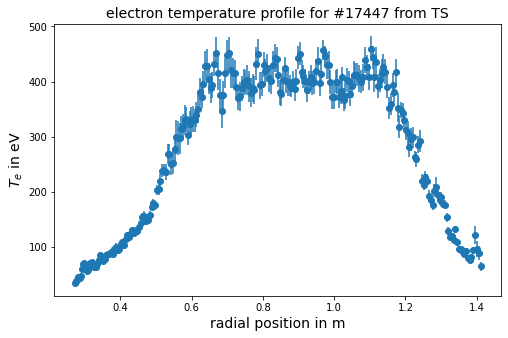

In [375]:
plt.errorbar(radius2,Te, yerr=Te_errors,fmt='o')

plt.xlabel("radial position in m",fontsize=14)
plt.ylabel(r"$T_e$ in eV",fontsize=14)
plt.title("electron temperature profile for #17447 from TS",fontsize=14)
plt.show()